In [67]:
# !pip install python-mnist

import numpy as np
from mnist import MNIST  
import matplotlib.pyplot as plt

load training data: (60000, 784), (60000, 10)
load testing data: (10000, 784), (10000, 10)


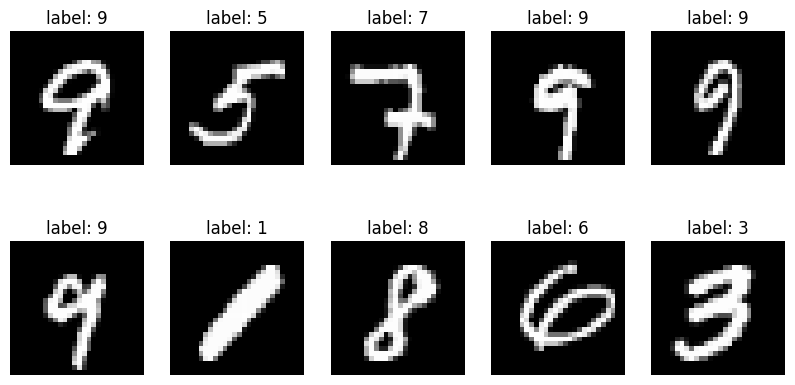

In [71]:
def one_hot_encode(labels, num_classes=10):
    labels = np.array(labels)
    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot

def load_mnist_data():
    mndata = MNIST('data')  # 替换为数据集的实际路径
    images, labels = mndata.load_training()
    test_images, test_labels = mndata.load_testing()
    
    # 将数据转换为 numpy array 并归一化
    images = np.array(images) / 255.0
    test_images = np.array(test_images) / 255.0

    # 将标签转换为 one-hot 编码
    labels = one_hot_encode(labels)
    test_labels = one_hot_encode(test_labels)
    print(f"load training data: {images.shape}, {labels.shape}")
    print(f"load testing data: {test_images.shape}, {test_labels.shape}")
    
    return images, labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_mnist_data()
# visualize the data
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        idx = random.randint(0, train_images.shape[0])
        axes[i, j].imshow(train_images[idx].reshape(28, 28), cmap='gray')
        axes[i, j].set_title(f'label: {np.argmax(train_labels[idx])}')
        axes[i, j].axis('off')
plt.show()



In [96]:
class BPNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, reg_lambda=0.001,
                 activation='sigmoid', loss='cross_entropy'):
        self.initial_learning_rate = learning_rate
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda
        self.activation = activation
        self.loss_type = loss

        if self.activation == 'sigmoid':
            # 初始化权重和偏置
            self.weights1 = np.random.randn(input_size, hidden_size) * 0.01
            self.bias1 = np.zeros((1, hidden_size))
            self.weights2 = np.random.randn(hidden_size, output_size) * 0.01
            self.bias2 = np.zeros((1, output_size))
        elif self.activation == 'relu':
            self.weights1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
            self.bias1 = np.zeros((1, hidden_size))
            self.weights2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
            self.bias2 = np.zeros((1, output_size))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return z * (1 - z)

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return np.where(z > 0, 1, 0)

    def activate(self, z):
        if self.activation == 'sigmoid':
            return self.sigmoid(z)
        elif self.activation == 'relu':
            return self.relu(z)
        else:
            raise ValueError("Unsupported activation function")

    def activate_derivative(self, z):
        if self.activation == 'sigmoid':
            return self.sigmoid_derivative(z)
        elif self.activation == 'relu':
            return self.relu_derivative(z)
        else:
            raise ValueError("Unsupported activation function derivative")
        
    def softmax(self, z):
        # 避免指数爆炸，减去最大值
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def softmax_derivative(self, z):
        return z * (1 - z)
    
    def forward(self, X):
        # 前向传播
        self.z1 = np.dot(X, self.weights1) + self.bias1
        self.a1 = self.activate(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        self.a2 = self.activate(self.z2)
        return self.a2

    def compute_loss(self, y, output):
        if self.loss_type == 'cross_entropy':
            # 交叉熵损失
            samples = y.shape[0]
            # 防止 log(0) 溢出，增加一个小的常数
            output = np.clip(output, 1e-12, 1 - 1e-12)
            log_likelihood = -np.sum(y * np.log(output)) / samples
            return log_likelihood
        elif self.loss_type == 'svm':
            # SVM损失
            margins = np.maximum(0, output - output[np.arange(output.shape[0]), np.argmax(y, axis=1)].reshape(-1, 1) + 1)
            margins[np.arange(output.shape[0]), np.argmax(y, axis=1)] = 0
            loss = np.sum(margins) / y.shape[0]
            return loss
        elif self.loss_type == 'mse':
            # 均方误差
            return np.mean(np.square(y - output))
        else:
            raise ValueError("Unsupported loss function")

    def backward(self, X, y, output):
        if self.loss_type == 'cross_entropy':
            # 输出层误差（交叉熵损失）
            output_error = output - y
        elif self.loss_type == 'svm':
            # 输出层误差（SVM损失）
            output_error = np.zeros_like(output)
            correct_class = np.argmax(y, axis=1)
            margins = output - output[range(output.shape[0]), correct_class].reshape(-1, 1) + 1
            output_error[margins > 0] = 1
            output_error[range(output.shape[0]), correct_class] -= np.sum(output_error, axis=1)
            output_error /= y.shape[0]
        elif self.loss_type == 'mse':
            # 输出层误差（均方误差）
            output_error = (output - y) / y.shape[0]
        else:
            raise ValueError("Unsupported loss function")

        output_delta = output_error * self.activate_derivative(self.a2)

        # 隐藏层误差
        hidden_error = output_delta.dot(self.weights2.T)
        hidden_delta = hidden_error * self.activate_derivative(self.a1)
        
        # 更新权重和偏置
        self.weights2 -= self.learning_rate * (self.a1.T.dot(output_delta) + self.reg_lambda * self.weights2)
        self.bias2 -= self.learning_rate * np.sum(output_delta, axis=0, keepdims=True)
        
        self.weights1 -= self.learning_rate * (X.T.dot(hidden_delta) + self.reg_lambda * self.weights1)
        self.bias1 -= self.learning_rate * np.sum(hidden_delta, axis=0, keepdims=True)

    def train(self, X, y, testX, testy, epochs=1000, scheduler=None):
        train_loss_list = []
        test_loss_list = []
        train_accuracy_list = []
        test_accuracy_list = []
        lr_list = []
        for epoch in range(epochs):
            # 前向传播
            output = self.forward(X)
            # 计算损失
            loss = self.compute_loss(y, output)
            # 反向传播并更新权重
            self.backward(X, y, output)
            # 学习率衰减
            self.learning_rate = scheduler(epoch) if scheduler else self.initial_learning_rate
            lr_list.append(self.learning_rate)
            
            # 每1轮输出一次损失,accuracy
            if epoch % 1 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")
                print(f"Accuracy = {np.mean(np.argmax(output, axis=1) == np.argmax(y, axis=1)):.4f}")
                test_output = self.forward(testX)
                test_loss = self.compute_loss(testy, test_output)
                print(f"Test loss = {test_loss:.4f}")
                print(f"Test accuracy = {np.mean(np.argmax(test_output, axis=1) == np.argmax(testy, axis=1)):.4f}")
                train_loss_list.append(loss)
                test_loss_list.append(test_loss)
                train_accuracy_list.append(np.mean(np.argmax(output, axis=1) == np.argmax(y, axis=1)))
                test_accuracy_list.append(np.mean(np.argmax(test_output, axis=1) == np.argmax(testy, axis=1)))
                
        return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list, lr_list



    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)


Epoch 0: Loss = 9.3321
Accuracy = 0.0554
Test loss = 10.1641
Test accuracy = 0.3113
Epoch 1: Loss = 10.1549
Accuracy = 0.3120
Test loss = 4.8747
Test accuracy = 0.4726
Epoch 2: Loss = 4.9404
Accuracy = 0.4674
Test loss = 5.4143
Test accuracy = 0.5152
Epoch 3: Loss = 5.4064
Accuracy = 0.5079
Test loss = 5.5354
Test accuracy = 0.4918
Epoch 4: Loss = 5.4945
Accuracy = 0.4900
Test loss = 5.6337
Test accuracy = 0.4323
Epoch 5: Loss = 5.6428
Accuracy = 0.4302
Test loss = 5.2141
Test accuracy = 0.4654
Epoch 6: Loss = 5.1518
Accuracy = 0.4692
Test loss = 4.3957
Test accuracy = 0.5087
Epoch 7: Loss = 4.4612
Accuracy = 0.5113
Test loss = 4.9369
Test accuracy = 0.4773
Epoch 8: Loss = 4.9947
Accuracy = 0.4689
Test loss = 4.0499
Test accuracy = 0.5215
Epoch 9: Loss = 4.0721
Accuracy = 0.5233
Test loss = 3.4749
Test accuracy = 0.6327
Epoch 10: Loss = 3.5535
Accuracy = 0.6245
Test loss = 2.8172
Test accuracy = 0.6973
Epoch 11: Loss = 2.8985
Accuracy = 0.6877
Test loss = 2.7176
Test accuracy = 0.6780


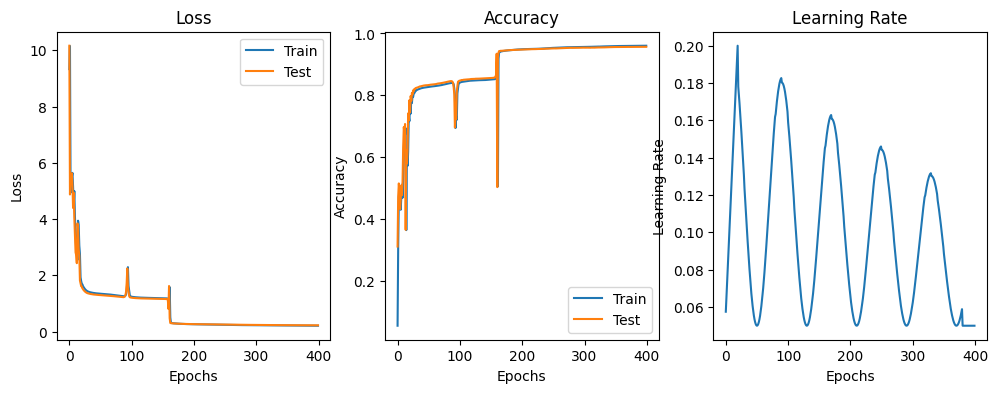

In [100]:
# 定义模型参数
input_size = 784         # 输入层神经元个数 (28*28)
hidden_size = 1024        # 隐藏层神经元个数
output_size = 10         # 输出层神经元个数 (10类)
learning_rate = 0.2
decay_rate = 0.98
reg_lambda = 0.01
epochs = 400

def scheduler(epoch):
    # Cosine annealing learning rate scheduler
    # decay to 0.01 of the initial learning rate
    # warmup to the initial learning rate in the first 20 epochs
    # T_max = 20
    # last 20 epochs with no cosine annealing
    if epoch < 20:
        lr = (learning_rate - 0.05) * (epoch + 1) / 20 + 0.05
    elif epoch < epochs - 20:
        lr = 0.05 + 0.5 * (learning_rate - 0.05) * (1 + np.cos((epoch - 10) * np.pi / 40)) * decay_rate ** (int((epoch - 20)/10))
    else:
        lr = 0.05
    return lr

# 初始化模型
model = BPNeuralNetwork(input_size, hidden_size, output_size, learning_rate, reg_lambda, activation='relu', loss='svm')

# 训练模型
train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list, lr_list = model.train(train_images, train_labels, test_images, test_labels, epochs, scheduler)

# 可视化训练过程 loss draw together, accuracy draw together
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_loss_list, label='Train')
plt.plot(test_loss_list, label='Test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(train_accuracy_list, label='Train')
plt.plot(test_accuracy_list, label='Test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(lr_list)
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()


